# **Part III: Convolutional neural networks**
Your task in Part III is to understand how to develop deep learning models with PyTorch. You need to design a convolutional neural network that classifies an MRI dataset of subjects' left hippocampus into one of two classes (cognitively normal or Alzheimer's disease). Each MRI dataset in Part III is a tensor of size 30x40x30. The diagnosis of subjects in the training set is either True (Alzheimer's disease) or False (cognitively normal). Your task is to determine the diganosis of subjects in the testing set, and submit your classification results via Kaggle. 

You should study the PyTorch tutorial before working on this notebook. Unlike in Parts I and II of the assignment, in Part III you will need GPU access. Make sure that you change the runtime type: click on the Runtime tab to the top-right of your notebook, select Change Runtime Type in the drop-down menu, then set your hardware accelerator to a GPU.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/SC42140/Train_Data.zip' -d ./
!unzip '/content/drive/MyDrive/SC42140/Test_Data.zip' -d ./

In [ ]:
# Import libraries 
import numpy as np
import pandas as pd
from time import time
from os import path
import random
from copy import deepcopy

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms
from torchsummary import summary

import matplotlib.pyplot as plt
from scipy.ndimage import rotate

## **MRI data exploration**

#### Custom PyTorch dataset class

In [ ]:
class MRIDataset(Dataset):
    
    def __init__(self, mode, data_df):
        """
        Args:
            img_dir (str): path to the CAPS directory containing preprocessed images
            data_df (DataFrame): metadata of the population.
                Columns include participant_id, session_id and diagnosis).
            transform (callable): list of transforms applied on-the-fly, chained with torchvision.transforms.Compose.
        """
        self.mode = mode
        self.data_df = data_df
        self.label_code = {True: 1, False: 0}

        self.size = self[0]['image'].shape
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'Diagnosis']
        label = self.label_code[diagnosis]
        subject_id = self.data_df.loc[idx, 'Subject_Num']
        if self.mode == 'train':
          image = torch.load('./Train_Data/Train_Subject_' + str(subject_id) + '_LHC.pt')
        elif self.mode == 'eval':
          image = torch.load('./Test_Data/Test_Subject_' + str(subject_id) + '_LHC.pt')

        sample = {'image': image, 'label': label, 'participant_id': 'P'+ str(subject_id)}
        return sample

#### Training set

In [ ]:
# Diagnosis of 20 first subjects in the training set
data_train_df = pd.read_csv('/content/drive/MyDrive/SC42140/training_labels.csv')
data_train_df.head(20)

,Subject_Num,Diagnosis
0,1,False
1,2,False
2,3,False
3,4,False
4,5,False
5,6,True
6,7,False
7,8,False
8,9,False
9,10,False


In [ ]:
# Instantiation of MRIDataset class
train_datasetLeftHC = MRIDataset('train', data_train_df)

In [ ]:
# Example for one study participant
index = 0
print('Diagnosis: ' + str(train_datasetLeftHC[index]['label']))
print('MRI dataset: ' + str(train_datasetLeftHC[index]['image']))

#### Visualization of left hippocampus MRI data

In [ ]:
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), dpi=100)
    fig.tight_layout(pad=1)
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

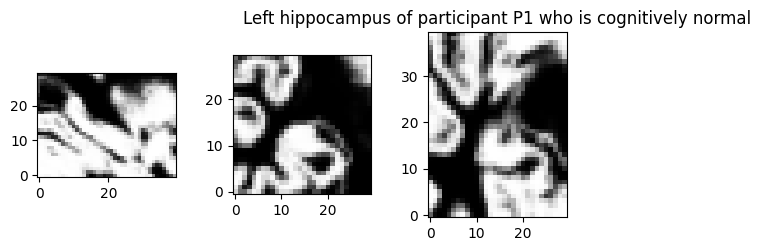

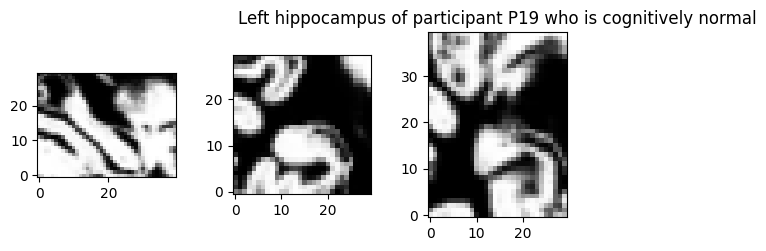

In [ ]:
# Plot slices of healthy left hippocampus
leftHC_pt = train_datasetLeftHC[0]['image']
slice_0 = leftHC_pt[0, 15, :, :]
slice_1 = leftHC_pt[0, :, 20, :]
slice_2 = leftHC_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.title("Left hippocampus of participant " + train_datasetLeftHC[0]['participant_id'] + " who is cognitively normal")
plt.show()

leftHC_pt = train_datasetLeftHC[18]['image']
slice_0 = leftHC_pt[0, 15, :, :]
slice_1 = leftHC_pt[0, :, 20, :]
slice_2 = leftHC_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.title("Left hippocampus of participant " + train_datasetLeftHC[18]['participant_id'] + " who is cognitively normal")
plt.show()

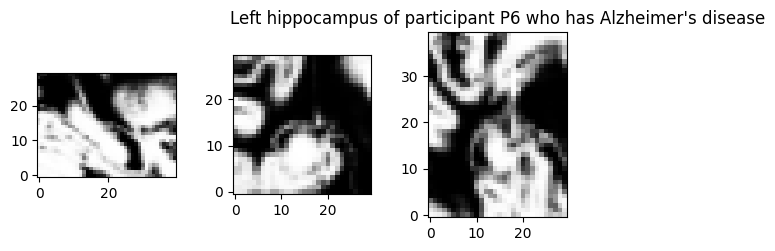

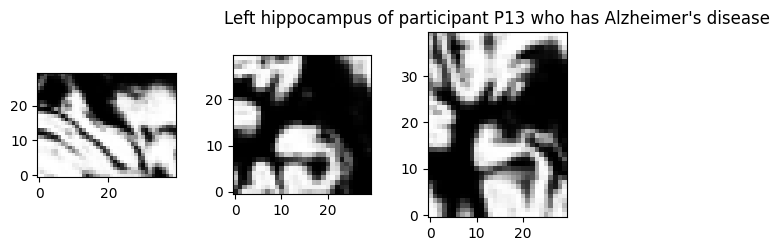

In [ ]:
# Plot slices of diseased left hippocampus 
leftHC_pt = train_datasetLeftHC[5]['image']
slice_0 = leftHC_pt[0, 15, :, :]
slice_1 = leftHC_pt[0, :, 20, :]
slice_2 = leftHC_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.title("Left hippocampus of participant " + train_datasetLeftHC[5]['participant_id'] + " who has Alzheimer's disease")
plt.show()

leftHC_pt = train_datasetLeftHC[12]['image']
slice_0 = leftHC_pt[0, 15, :, :]
slice_1 = leftHC_pt[0, :, 20, :]
slice_2 = leftHC_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.title("Left hippocampus of participant " + train_datasetLeftHC[12]['participant_id'] + " who has Alzheimer's disease")
plt.show()

## **Convolutional neural network architecture**

#### Feature maps

The outputs of the layers in a convolutional network are called feature maps.
Their size is written with the format: 

> `n_channels @ dim1 x dim2 x dim3`

For a 3D CNN the dimension of the feature maps is actually 5D as the first
dimension is the batch size. This dimension is added by the `DataLoader` of
Pytorch which stacks the 4D tensors computed by a `Dataset`.

#### Convolutions (`nn.Conv3d`)

The main arguments of this layer are the input channels, the output channels
(number of filters trained) and the size of the filter (or kernel). If an
integer `k` is given the kernel will be a cube of size `k`. It is possible to
construct rectangular kernels by entering a tuple (but this is very rare).

You will find below an illustration of how a single filter produces its
output feature map by parsing the one feature map. The size of the output
feature map produced depends of the convolution parameters and can be
computed with the following formula:

> $O_i = \frac{I_i-k+2P}{S} + 1$

*   $O_i$ the size of the output along the ith dimension
*   $I_i$ the size of the input along the ith dimension
*   $k$ the size of the kernel
*   $P$ the padding value
*   $S$ the stride value

To be able to parse all the feature maps of the input, one filter is actually
a 4D tensor of size `(input_channels, k, k, k)`. The ensemble of all the
filters included in one convolutional layer is then a 5D tensor stacking all
the filters of size `(output_channels, input_channels, k, k, k)`.

Each filter is also associated to one bias value that is a scalar added to
all the feature maps it produces. Then the bias is a 1D vector of size
`output_channels`.

#### Batch Normalization (`nn.BatchNorm3d`)

Normalization of feature maps. The following formula is applied on
each feature map  $FM_i$:

> $FM^{normalized}_i = \frac{FM_i - mean(FM_i)}{\sqrt{var(FM_i) + \epsilon}} * \gamma_i + \beta_i$

*   $\epsilon$ is a hyperparameter of the layer (default=1e-05)
*   $\gamma_i$ is the value of the scale for the ith channel (learnable parameter)
*   $\beta_i$ is the value of the shift for the ith channel (learnable parameter)

This layer does not have the same behaviour during training and evaluation,
this is why it is needed to put the model in evaluation mode in the test
function with the command `.eval()`

#### Activation function (`nn.LeakyReLU`)

In order to introduce non-linearity in the model, an activation function is
introduced after the convolutions. It is applied on all intensities
independently.

#### Pooling function (`PadMaxPool3d`)

The structure of the pooling layer is very similar to the convolutional
layer: a kernel is passing through the input with a defined size and stride.
However there is no learnable parameters in this layer, the kernel outputing
the maximum value of the part of the feature map it covers.

Here is an example in 2D of the standard layer of pytorch `nn.MaxPool2d`:

![nn.MaxPool2d behaviour](https://drive.google.com/uc?id=1qh9M9r9mfpZeSD1VjOGQAl8zWqBLmcKz)

We can observe that the last column may not be used depending on the size of
the kernel/input and stride value.

This is why the custom module `PadMaxPool` was defined to pad the input in
order to exploit information from the whole feature map.

In [ ]:
class PadMaxPool3d(nn.Module):
    """A MaxPooling module which deals with odd sizes with padding"""
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool3d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool3d(kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad3d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride - f_maps.size(i + 2) % self.stride for i in range(3)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0 
                
        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)
        
        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output

Here is an illustration of `PadMaxPool` behaviour. If the number of columns is odd, a column is added to avoid
losing data:

<a href="PadMaxPool behaviour"><img src="https://drive.google.com/uc?id=14R_LCTiV0N6ZXm-3wQCj_Gtc1LsXdQq_" style="height: 200px;"></a>

Similarly, the formula to find the size of the output feature map is:

> $O_i = ceil(\frac{I_i-k+2P}{S}) + 1$

#### Dropout (`nn.Dropout`) 
The aim of a dropout layer is to replace a fixed proportion of the input
values by 0 during training only.

This layer does not have the same behaviour during training and evaluation,
this is why it is needed to put the model in evaluation mode in the test
function with the command `.eval()`

In [ ]:
dropout = nn.Dropout(0.5)
input_tensor = torch.rand(10)
output_tensor = dropout(input_tensor)
print("Input \n", input_tensor)
print()
print("Output \n", output_tensor)

Input 
 tensor([0.0632, 0.3177, 0.7134, 0.3275, 0.4105, 0.3300, 0.6991, 0.9556, 0.9776,
        0.1437])

Output 
 tensor([0.0000, 0.6354, 0.0000, 0.0000, 0.0000, 0.6600, 1.3982, 0.0000, 0.0000,
        0.0000])


#### Fully-Connected Layers (`nn.Linear`)

The fully connected layers take as input 2D vectors of size `(batch_size,
N)`. They have two mandatory arguments, the number of values per batch of the
input and the number of values per batch of the output.

Each output neuron in a FC layer is a linear combination of the inputs + a
bias.

In [ ]:
fc = nn.Linear(16, 2)
print("Weights shape \n", fc.weight.shape)
print()
print("Bias shape \n", fc.bias.shape)

Weights shape 
 torch.Size([2, 16])

Bias shape 
 torch.Size([2])


#### Network design
Construct here the network corresponding to the scheme and the following
description:

![Scheme of the network](https://drive.google.com/uc?id=1Qi-ictqudBX4ToBXzqT5w57RHrkn3MPR)

The network includes 3 convolutional blocks composed by a convolutional layer
(kernel size = 3, padding = 1, stride = 1), a batch normalization, a
LeakyReLU activation and a MaxPooling layer. The 3 successive layers include
respectively 8, 16 and 32 filters. Then, the feature maps array is flattened in a 1D array to enter a fully-connected layer. Between the convolutional and the fully-connected layers, a dropout layer with a dropout rate of 0.5 is inserted.

You need to create the layers composing the neural network hereunder:

In [ ]:
class CustomNetwork(nn.Module):

    def __init__(self):
        super(CustomNetwork, self).__init__()
        # Create the layers composing the network.
        # TIP: you can use Sequential to avoid naming all the layers one by one.
        pass 
        
    def forward(self, x):
        # Compose the forward operation using the layers defined in __init__
        pass

#### Train & Test

Complete the `train` method in order to iteratively update the weights of the
network. Here the model leading to the lowest loss on the training set at the end of an epoch is returned. The `test` and the 'compute_metrics' methods are provided. 

In [ ]:
def train(model, train_loader, criterion, optimizer, n_epochs):
    """
    Method used to train the convolutional neural network classification model
    
    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training

    Returns:
        best_model: (nn.Module) the trained neural network
    """
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()

        for i, data in enumerate(train_loader, 0):
            # Complete the training iteration

        _, train_metrics = test(model, train_loader, criterion)

        print(f"Epoch {epoch}: loss = {train_metrics['mean_loss']:.4f}, "
            f"accuracy = {train_metrics['accuracy']:.4f}, "
            f"F1-score = {train_metrics['F1-score']:.4f}, ")

        if train_metrics['mean_loss'] < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = train_metrics['mean_loss']
    
    return best_model

In [ ]:
def test(model, data_loader, criterion):
    """
    Method used to test the convolutional neural network classification model
    
    Args:
        model: (nn.Module) the neural network
        data_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
    
    Returns:
        results_df: (DataFrame) the label predicted for every subject
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0
    
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = nn.Softmax(dim=1)(outputs)
            _, predicted = torch.max(outputs.data, 1)

            for idx, sub in enumerate(data['participant_id']):
                row = [sub, probs[idx, 0].item(), probs[idx, 1].item(), labels[idx].item(), predicted[idx].item()]
                row_df = pd.DataFrame([row], columns=columns)
                results_df = pd.concat([results_df, row_df])

    results_metrics = compute_metrics(results_df.true_label.values, results_df.predicted_label.values)
    results_df.reset_index(inplace=True, drop=True)
    results_metrics['mean_loss'] = total_loss / len(data_loader.dataset)
    
    return results_df, results_metrics

In [ ]:
def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))
   
    metrics_classification = dict()
    metrics_classification['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
   
    # Precision 
    if tp + fp !=0: 
      metrics_classification['precision'] = tp / (tp + fp)
    else: 
      metrics_classification['precision'] = 0.0

    # Recall or sensitivity 
    if tp + fn != 0:
      metrics_classification['recall'] = tp / (tp + fn)
    else:
      metrics_classification['recall'] = 0.0
       
    # Specificity 
    if fp + tn != 0:
      metrics_classification['specificity'] = tn / (fp + tn)
    else:
      metrics_classification['specificity'] = 0.0
       
    if metrics_classification['precision'] + metrics_classification['recall'] != 0: 
      metrics_classification['F1-score'] = 2 * metrics_classification['precision'] * metrics_classification['recall'] / (metrics_classification['precision'] + metrics_classification['recall'])
    else: 
      metrics_classification['F1-score'] = 0 
    metrics_classification['balanced_accuracy'] = (metrics_classification['recall'] + metrics_classification['specificity']) / 2
   
    return metrics_classification

## **Model training and prediction**




#### Hyperparameter choice 

All hyperparameters influence the classification model training process, but one of the most important is the learning rate. Try different learning rate between $10 ^{-6}$ and $10 ^{-2}$ and observe the differences of loss variations during training. To increase the training speed you can also increase the batch size. Observe how these different choices of hyperparameters affect convergence.

In [ ]:
# Hyperparameter choice 
learning_rate = 10**-3
n_epochs = 30 
batch_size = 32 

In [ ]:
# Send the neural network to the GPU
modelLeftHC = CustomNetwork().cuda()

# Neural network inspection
summary(modelLeftHC, input_size=(1, 30, 40, 30))
plt.show()

In [ ]:
# Define data loader 
train_loaderLeftHC = DataLoader(train_datasetLeftHC, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Criterion and optimizer choice 
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(modelLeftHC.parameters(), learning_rate)

# Save classification model
best_modelLeftHC = train(modelLeftHC, train_loaderLeftHC, criterion, optimizer, n_epochs)

# Print performance metrics on the training set
train_resultsLeftHC_df, train_metricsLeftHC = test(best_modelLeftHC, train_loaderLeftHC, criterion)
print('Metrics on training dataset: ' + str(train_metricsLeftHC))